Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import the necessary libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import random 

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist
import tensorflow as tf

sns.set(style='white', context='notebook', palette='deep')

Data preparation

In [2]:
import os
print(os.listdir('../input/digit-recognizer'))

['sample_submission.csv', 'train.csv', 'test.csv']


In [3]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')
sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

print("Data are Ready!!")

Data are Ready!!


In [4]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


Set data features and Target labels

In [7]:
X_train = train.drop(['label'], 1).values
y_train = train['label'].values

Is The Target Label Balanced ?

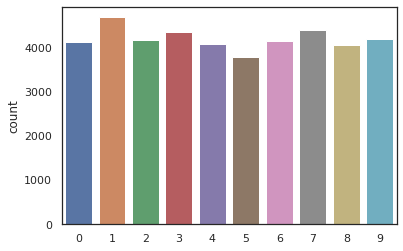

In [8]:
sns.countplot(y_train);

Normalization
I perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [9]:
X_train = X_train / 255.0
test = test / 255.0

Reshape

In [10]:
X_train = X_train.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

One-Hot Encoding
Convert label to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

In [11]:
y_train = to_categorical(y_train, num_classes = 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

Split the train and the validation set for the fitting

In [12]:
X_train, X_val, y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=2)

In [13]:
X_train.shape, X_val.shape, y_train.shape, Y_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

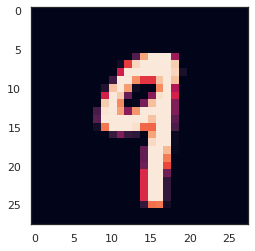

In [16]:
g = plt.imshow(X_train[2][:,:,0])

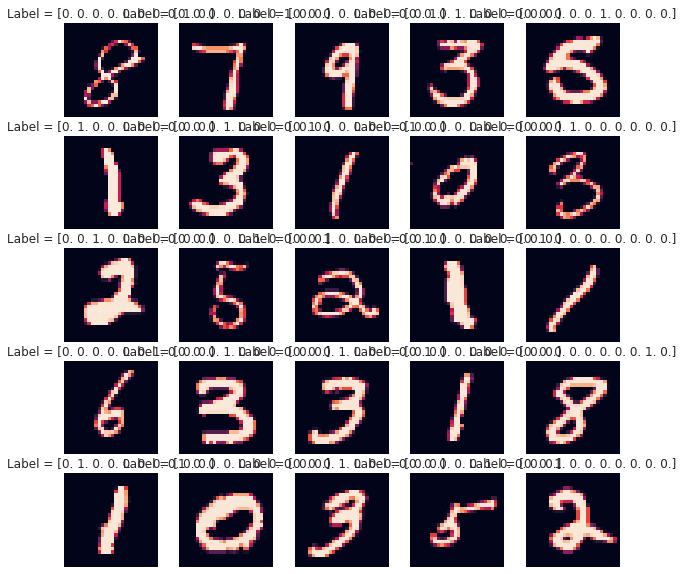

In [17]:
def display_multiple_images(train_or_test, caption, title):
    
    '''Displays the first 25 images of the dataset'''

    r = 5
    c = 5 

    fig = plt.figure(figsize = (10, 10))

    for i in range(r * c): 
        fig.add_subplot(r, c, i + 1)
        plt.imshow(train_or_test[i]) 
        plt.title(caption + ' = ' + str(title[i]))
        plt.axis("off")
        
display_multiple_images(X_train, 'Label', y_train)

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 64 filters for the two firsts conv2D layers and 64 filters for the two second layers and 64 filters for one third layers and 256 for the last one. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [19]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)       

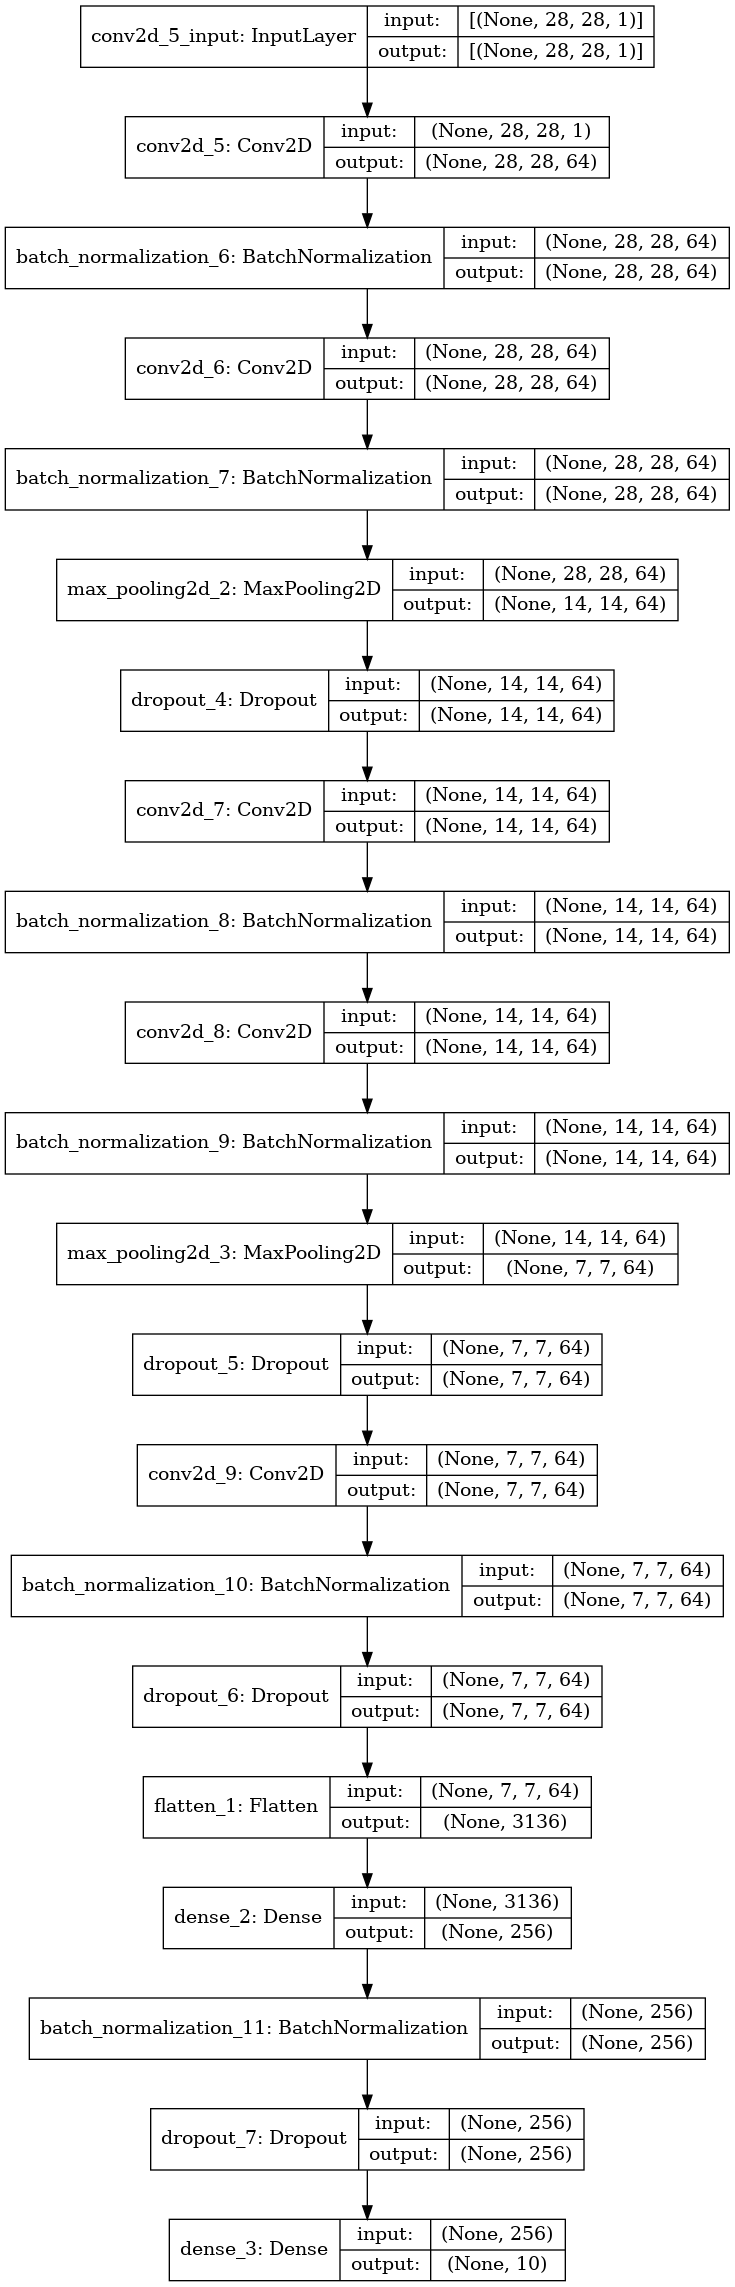

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

In [22]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [23]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Data augmentation

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [25]:
#Data Augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#datagen.fit(X_train)
train_gen = datagen.flow(X_train,y_train, batch_size=128)

In [26]:
epochs = 100
batch_size = 128
train_steps = X_train.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [28]:
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = (X_val,Y_val),
                              validation_steps = X_val.shape[0], 
                              callbacks=[es, rp])

Epoch 1/100
295/295 [==============================] - 21s 72ms/step - loss: 0.2491 - accuracy: 0.9218 - val_loss: 3.0346 - val_accuracy: 0.50380.91 - ETA: 0s - loss: 0.2622 - ac - ETA: 0s - loss: 0.2535 - accura
Epoch 2/100
295/295 [==============================] - 19s 65ms/step - loss: 0.0894 - accuracy: 0.9737 - val_loss: 0.0838 - val_accuracy: 0.9750
Epoch 3/100
295/295 [==============================] - 21s 72ms/step - loss: 0.0614 - accuracy: 0.9817 - val_loss: 0.0342 - val_accuracy: 0.9900
Epoch 4/100
295/295 [==============================] - 19s 63ms/step - loss: 0.0528 - accuracy: 0.9846 - val_loss: 0.0264 - val_accuracy: 0.9907
Epoch 5/100
295/295 [==============================] - 20s 68ms/step - loss: 0.0465 - accuracy: 0.9859 - val_loss: 0.0318 - val_accuracy: 0.9898
Epoch 6/100
295/295 [==============================] - 19s 65ms/step - loss: 0.0415 - accuracy: 0.9876 - val_loss: 0.0396 - val_accuracy: 0.9862
Epoch 7/100
295/295 [==============================] - 21s 71m

Training and validation curves

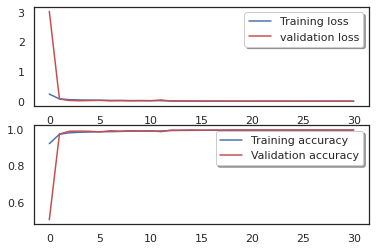

In [29]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Confusion matrix
Confusion matrix can be very helpful to see your model drawbacks and behavior.

I plot the confusion matrix of the validation results.

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

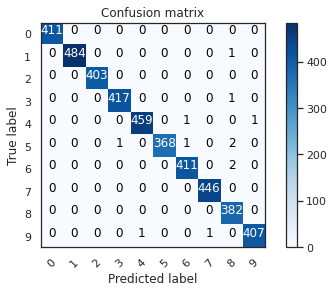

In [31]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [32]:
# Show some wrong results, and the difference between the predicted label and the real labe
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

Displaying The Errors And Showing The Top 6 Errors And It's True Label

In [33]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

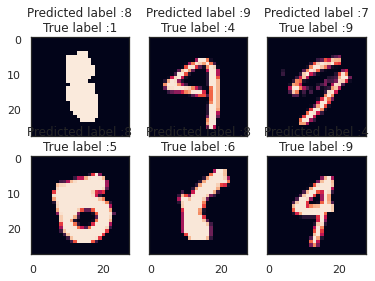

In [34]:
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)


Prediction validation results

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train, random_state = 0)

In [39]:
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
make_prediction = (((test_df.values).reshape(-1, 28, 28, 1)) / 255.0)
final_labels = model.predict(make_prediction)
final_labels = np.argmax(final_labels, axis = 1)

In [40]:
model.evaluate(X_test, y_test, batch_size = 64, verbose = 1)

60/60 [==============================] - 1s 5ms/step - loss: 0.0038 - accuracy: 0.9995


[0.0037745926529169083, 0.9994708895683289]

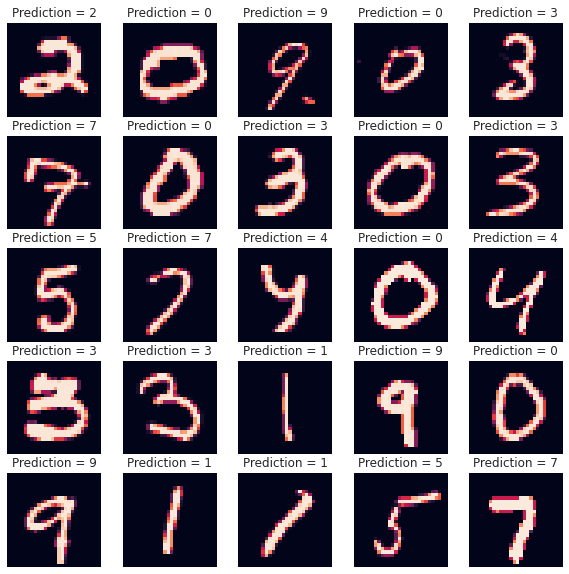

In [41]:
display_multiple_images(test_df.values.reshape(-1, 28, 28, 1), 'Prediction', final_labels)